# Web Scraping with Python
Scraping NBA Data

http://nyloncalculus.com/2015/09/07/nylon-calculus-101-data-scraping-with-python/

Feb 2016

In [1]:
import sys
import urllib
from urllib import urlopen
import bs4
from bs4 import BeautifulSoup #to install: "pip install BeautifulSoup"
import pandas as pd #to install: http://pandas.pydata.org/getpandas.html
import html5lib #to install: "pip install html5lib"

print('Python version:', sys.version_info)
print('Urllib.request version:', urllib.__version__)
print('BeautifulSoup version:', bs4.__version__)
print('Pandas version:', pd.__version__)

('Python version:', sys.version_info(major=2, minor=7, micro=9, releaselevel='final', serial=0))
('Urllib.request version:', '1.17')
('BeautifulSoup version:', '4.3.2')
('Pandas version:', '0.15.2')


In [2]:
"""
Getting data into bs4
"""

#url to scrape from
url = "http://www.basketball-reference.com/draft/NBA_2014.html"

#html from given url
html = urlopen(url)

soup = BeautifulSoup(html)

type(soup)

bs4.BeautifulSoup

In [3]:
"""
Getting Col Headers
"""

#column headers in 2nd row
col_headers_raw = soup.findAll('tr', limit=2)[1].findAll('th')

#getting text from each col header
col_headers = [th.getText() for th in col_headers_raw]

In [4]:
"""
Getting Data
"""

data_rows = soup.findAll('tr')[2:] #skip first 2 (header) rows

#2d array => nested list comp.
player_data = [[td.getText() for td in data_rows[i].findAll('td')] 
               for i in range(len(data_rows))]

#equivalent action
player_data_02 = []

for i in range(len(data_rows)):
    row =[]
    for td in data_rows[i].findAll('td'):
        row.append(td.getText())
    player_data_02.append(row)
    
player_data == player_data_02

True

In [5]:
"""
data in pandas df
"""

df = pd.DataFrame(player_data, columns=col_headers)

df.head(3) #preview first 3 rows. note missing data.

,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,...,3P%,FT%,MP,PTS,TRB,AST,WS,WS/48,BPM,VORP
0,1,1,CLE,Andrew Wiggins,University of Kansas,2,140,5006,2594,585,...,.284,.755,35.8,18.5,4.2,2.0,4.8,.046,-2.3,-0.4
1,2,2,MIL,Jabari Parker,Duke University,2,78,2323,951,407,...,.160,.748,29.8,12.2,5.2,1.6,3.7,.077,-2.1,-0.1
2,3,3,PHI,Joel Embiid,University of Kansas,,,,,,...,,,,,,,,,,


In [6]:
"""
Cleaning data: Removing empty rows
"""

#removing rows w/o player names
df = df[df.Player.notnull()] 

#check no empty rows
df[df['Pk'].isnull()]

,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,TRB,...,3P%,FT%,MP,PTS,TRB,AST,WS,WS/48,BPM,VORP


In [7]:
"""
Cleaning data: Renaming columns
"""

#replace "WS/48"
df.rename(columns={'WS/48':'WS_per_48'}, inplace=True)

#replace "%"
df.columns = [name.replace('%', '_Perc') for name in df.columns]

#add "per_G" to per game columns (14-17)
df.columns.values[14:18] = [name + "_per_G" for name in df.columns.values[14:18]]

print df.columns #get names of all columns

Index([u'Rk', u'Pk', u'Tm', u'Player', u'College', u'Yrs', u'G', u'MP', u'PTS', u'TRB', u'AST', u'FG_Perc', u'3P_Perc', u'FT_Perc', u'MP_per_G', u'PTS_per_G', u'TRB_per_G', u'AST_per_G', u'WS', u'WS_per_48', u'BPM', u'VORP'], dtype='object')


In [8]:
"""
Changing Data Types
"""

#convert numeric data types
df = df.convert_objects(convert_numeric=True)

#fill missing numbers w/ 0
df= df[:].fillna(0)

#setting years and assists to int
df.loc[:,'Yrs':'AST'] = df.loc[:,'Yrs':'AST'].astype(int)

#look at data types
df.dtypes

Rk             int64
Pk             int64
Tm            object
Player        object
College       object
Yrs            int64
G              int64
MP             int64
PTS            int64
TRB            int64
AST            int64
FG_Perc      float64
3P_Perc      float64
FT_Perc      float64
MP_per_G     float64
PTS_per_G    float64
TRB_per_G    float64
AST_per_G    float64
WS           float64
WS_per_48    float64
BPM          float64
VORP         float64
dtype: object

In [9]:
"""
Adding and Deleting Columns
"""

#add column
df.insert(0, 'Draft_Yr', 2014)

#remove column w/ redundant info
df.drop('Rk', axis='columns', inplace=True)

df.columns

Index([u'Draft_Yr', u'Pk', u'Tm', u'Player', u'College', u'Yrs', u'G', u'MP', u'PTS', u'TRB', u'AST', u'FG_Perc', u'3P_Perc', u'FT_Perc', u'MP_per_G', u'PTS_per_G', u'TRB_per_G', u'AST_per_G', u'WS', u'WS_per_48', u'BPM', u'VORP'], dtype='object')

In [10]:
"""
Scraping and Cleaning for all Drafts 1966 - 2015
(Takes awhile to run...)
"""

url_template = "http://www.basketball-reference.com/draft/NBA_{year}.html"

draft_df = pd.DataFrame()

for year in range(1966, 2016):
    url = url_template.format(year=year)
    html = urlopen(url)
    
    #if you get an error here: "pip install --upgrade lxml"
    soup = BeautifulSoup(html, 'html5lib')
    
    #get our player data
    data_rows = soup.findAll('tr')[2:]
    player_data = [[td.getText() for td in data_rows[i].findAll('td')]
                   for i in range(len(data_rows))]
    
    
    #turn yearly data into a DF
    year_df = pd.DataFrame(player_data, columns=col_headers)
    
    #create and insert Draft_Yr column
    year_df.insert(0, 'Draft_Yr', year)
    
    #append to big df
    draft_df = draft_df.append(year_df, ignore_index=True)

draft_df.head()

,Draft_Yr,Rk,Pk,Tm,Player,College,Yrs,G,MP,PTS,...,3P%,FT%,MP,PTS,TRB,AST,WS,WS/48,BPM,VORP
0,1966,1,1,NYK,Cazzie Russell,University of Michigan,12,817,22213,12377,...,,.827,27.2,15.1,3.8,2.2,51.7,.112,-2.0,0.1
1,1966,2,2,DET,Dave Bing,Syracuse University,12,901,32769,18327,...,,.775,36.4,20.3,3.8,6.0,68.8,.101,0.6,8.5
2,1966,3,3,SFW,Clyde Lee,Vanderbilt University,10,742,19885,5733,...,,.614,26.8,7.7,10.3,1.1,33.5,.081,-2.4,-0.6
3,1966,4,4,STL,Lou Hudson,University of Minnesota,13,890,29794,17940,...,,.797,33.5,20.2,4.4,2.7,81.0,.131,0.1,5.9
4,1966,5,5,BAL,Jack Marin,Duke University,11,849,24590,12541,...,,.843,29.0,14.8,5.2,2.1,59.3,.116,-2.8,-1.4


In [11]:
"""
Cleaning Data
"""

#get rid of empty rows
draft_df = draft_df[draft_df.Player.notnull()]

#proper type
draft_df = draft_df.convert_objects(convert_numeric=True)

#replace NaN w/ 0s
draft_df = draft_df[:].fillna(0)

#rename columns
draft_df.rename(columns={'WS/48':'WS_per_48'}, inplace=True)

#change % symbol
draft_df.columns = [name.replace('%', '_Perc') for name in draft_df.columns.values]

#add per_G to per game stats
draft_df.columns.values[15:19] = [name + "_per_G" for name in draft_df.columns[15:19]]

#change data types to int
draft_df.loc[:, 'Yrs':'AST'] = draft_df.loc[:, 'Yrs':'AST'].astype(int)
draft_df['Pk'] = draft_df['Pk'].astype(int)

#delete the 'Rk' column
draft_df.drop('Rk', axis='columns', inplace=True)

print draft_df.columns
print draft_df.dtypes

Index([u'Draft_Yr', u'Pk', u'Tm', u'Player', u'College', u'Yrs', u'G', u'MP', u'PTS', u'TRB', u'AST', u'FG_Perc', u'3P_Perc', u'FT_Perc', u'MP_per_G', u'PTS_per_G', u'TRB_per_G', u'AST_per_G', u'WS', u'WS_per_48', u'BPM', u'VORP'], dtype='object')
Draft_Yr       int64
Pk             int64
Tm            object
Player        object
College       object
Yrs            int64
G              int64
MP             int64
PTS            int64
TRB            int64
AST            int64
FG_Perc      float64
3P_Perc      float64
FT_Perc      float64
MP_per_G     float64
PTS_per_G    float64
TRB_per_G    float64
AST_per_G    float64
WS           float64
WS_per_48    float64
BPM          float64
VORP         float64
dtype: object


In [12]:
"""
Writing Data to CSV
"""
draft_df.to_csv("draft_data_1966_to_2015.csv")
print 'done'

done


/Users/bxie/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


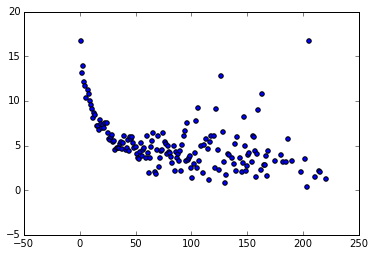

In [13]:
"""
Bonus! Basic Visualization
"""

#plotting
import matplotlib.pyplot as plt
    
#making plots look pretty
%matplotlib inline
# matplotlib.style.use('ggplot')
# pd.options.display.mpl_style = 'default'

#grouping players by pick, ignoring those w/ 0 ppg (missing data)
grouped_rk = draft_df[draft_df.PTS_per_G>0].groupby('Pk')

#getting mean points per game of each pick
avg_ppg = grouped_rk['PTS_per_G'].mean()

#plotting Avg PPG by Pick Number
plt.scatter(avg_ppg.index, avg_ppg)

#Noise at picks after 100 probably due to dirty data (I filtered out players w/ 0 ppg since it was missing data)

#NB: Had issues adding labels and title to plot...IDK why